In [1]:
# 분석할 폴더의 웨이트 파일 목록 확인하기
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 분석할 폴더 경로
path = './OverlapTransformer/2024-10-14_16-40-13'

# 특정 폴더의 피클 파일들을 불러오기
pickle_files = [f for f in os.listdir(path) if f.endswith('.pkl')]  # .pkl 확장자 파일들
pickle_files.sort()
for idx, p in enumerate(pickle_files):
    print('file {}:'.format(idx), p)


file 0: epoch_66.pkl
file 1: epoch_83.pkl
file 2: epoch_best_22.pkl
file 3: epoch_best_36.pkl
file 4: epoch_best_42.pkl
file 5: epoch_best_47.pkl


In [2]:
# 피클 파일들의 데이터를 데이터프레임으로 변환하는 함수
def load_pickle_and_convert_df(pickle_files):
    # 피클 파일들의 데이터를 데이터프레임으로 변환
    dataframes_dict = {}

    for file_name in pickle_files:
        file_path = os.path.join(path, file_name)  # 피클 파일 경로
        
        # 피클 파일 불러오기
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        
        # 데이터가 리스트로 구성되어 있는지 확인 후 데이터프레임으로 변환
        df = pd.DataFrame(data)

        # expanded_df = pd.json_normalize(df)  # 각 행의 딕셔너리를 개별 컬럼으로 변환
        thresholds = np.linspace(0.001, 0.8, 500)
        df.insert(0, 'Thresholds', thresholds[:len(df)])
        
        dataframes_dict[file_name.split('.')[0]] = df  # 파일 이름을 키로 데이터프레임 리스트 저장
    return dataframes_dict

In [3]:
# plot 관련 함수
# Updated function to adjust the direction of the max value annotation arrow to point downward
def plot_metric_above_threshold(x_label, y_label, data, threshold=0.8):
    data_keys = list(data.keys())
    for key in data_keys:
        df = data[key]
        # Filtering data to include only F1-Score values above the threshold
        filtered_df = df[df[y_label] >= threshold]
        
        if not filtered_df.empty:
            plt.plot(filtered_df[x_label], filtered_df[y_label], marker='o', markersize=1, label=key)
            
            # Marking the max value on the y-axis within the filtered range
            max_value = filtered_df[y_label].max()
            max_index = filtered_df[y_label].idxmax()
            plt.axhline(y=max_value, color='r', linestyle='--', linewidth=0.5)
            plt.annotate(f'Max: {max_value:.2f}', 
                         xy=(filtered_df[x_label][max_index], max_value), 
                         xytext=(filtered_df[x_label][max_index], max_value - 0.05),  # Arrow pointing downward
                         arrowprops=dict(arrowstyle='->', lw=0.5))

    plt.title(y_label + "Values Above 0.8")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()  # Adding legend to indicate which line corresponds to which key
    plt.grid(True)
    plt.show()

def plot_f1_and_recall_near_threshold(metric_df, threshold=0.4):
    data_keys = list(metric_df.keys())
    
    # Plotting F1-Score and Recall near the given threshold
    plt.figure(figsize=(10, 6))
    
    for key in data_keys:
        if isinstance(metric_df[key], list):
            df = metric_df[key][0]
        else:
            df = metric_df[key]
        
        # Find the closest threshold to the given threshold (default 0.4)
        threshold_diff = (df["Thresholds"] - threshold).abs()
        closest_index = threshold_diff.idxmin()
        
        closest_threshold_value = df.loc[closest_index, "Thresholds"]
        f1_at_closest_threshold = df.loc[closest_index, "F1-Score"]
        recall_at_closest_threshold = df.loc[closest_index, "Recall (TPR)"]
        
        # Plot F1-Score and Recall at the closest threshold
        plt.plot(df["Thresholds"], df["F1-Score"], label=f'{key} - F1-Score')
        plt.plot(df["Thresholds"], df["Recall (TPR)"], label=f'{key} - Recall', linestyle='--')
        
        # Annotate the closest point to the threshold with F1-Score and Recall values
        plt.annotate(f'Closest F1: {f1_at_closest_threshold:.2f}', 
                     xy=(closest_threshold_value, f1_at_closest_threshold), 
                     xytext=(closest_threshold_value, f1_at_closest_threshold + 0.05),
                     arrowprops=dict(arrowstyle='->', lw=0.5))
        
        plt.annotate(f'Closest Recall: {recall_at_closest_threshold:.2f}', 
                     xy=(closest_threshold_value, recall_at_closest_threshold), 
                     xytext=(closest_threshold_value, recall_at_closest_threshold - 0.05),
                     arrowprops=dict(arrowstyle='->', lw=0.5))
        
        # Highlight the closest threshold with a vertical line
        plt.axvline(x=closest_threshold_value, color='gray', linestyle='--', linewidth=0.5)

    # Final plot adjustments
    plt.title(f"F1-Score and Recall near Threshold {threshold}")
    plt.xlabel("Thresholds")
    plt.ylabel("Scores")
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# 데이터프레임의 구조를 출력하는 함수
def show_dataframe_structure(df: pd.DataFrame):
    """
    데이터프레임의 구조를 출력합니다.
    
    Args:
    df (pd.DataFrame): 분석할 데이터프레임
    
    Returns:
    None
    """
    print("데이터프레임의 구조:")
    print("열 이름:", df.columns.tolist())
    print("데이터 유형:\n", df.dtypes)
    print("데이터의 일부:\n", df.head())

In [5]:
# 피클 파일들의 데이터를 불러오고 데이터프레임으로 변환
metric_df = load_pickle_and_convert_df(pickle_files=pickle_files)
metric_df_keys = list(metric_df.keys())
for key in metric_df_keys:
    show_dataframe_structure(metric_df[key])

데이터프레임의 구조:
열 이름: ['Thresholds', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives', 'Precision', 'Recall (TPR)', 'F1-Score', 'Accuracy', 'False Positive Rate (FPR)', 'Top-5 Recall']
데이터 유형:
 Thresholds                   float64
True Positives                 int64
True Negatives                 int64
False Positives                int64
False Negatives                int64
Precision                    float64
Recall (TPR)                 float64
F1-Score                     float64
Accuracy                     float64
False Positive Rate (FPR)    float64
Top-5 Recall                 float64
dtype: object
데이터의 일부:
    Thresholds  True Positives  True Negatives  False Positives  \
0    0.001000               0            4335                0   
1    0.002601               0            4335                0   
2    0.004202               0            4335                0   
3    0.005804               0            4335                0   
4    0.007405            

epoch_66's Best F1-Score:	 0.7579908675799087, 	Recall: 0.7410714285714286, 	at thresholds: 0.3564669338677355
epoch_83's Best F1-Score:	 0.799459824442944, 	Recall: 0.7072879330943848, 	at thresholds: 0.38688977955911824
epoch_best_22's Best F1-Score:	 0.8144119646498981, 	Recall: 0.7199519230769231, 	at thresholds: 0.3484609218436874
epoch_best_36's Best F1-Score:	 0.8066225165562914, 	Recall: 0.7302158273381295, 	at thresholds: 0.36607414829659324
epoch_best_42's Best F1-Score:	 0.8144544822793606, 	Recall: 0.7001194743130227, 	at thresholds: 0.3148356713426854
epoch_best_47's Best F1-Score:	 0.8345612860013397, 	Recall: 0.7443249701314217, 	at thresholds: 0.38368737474949904


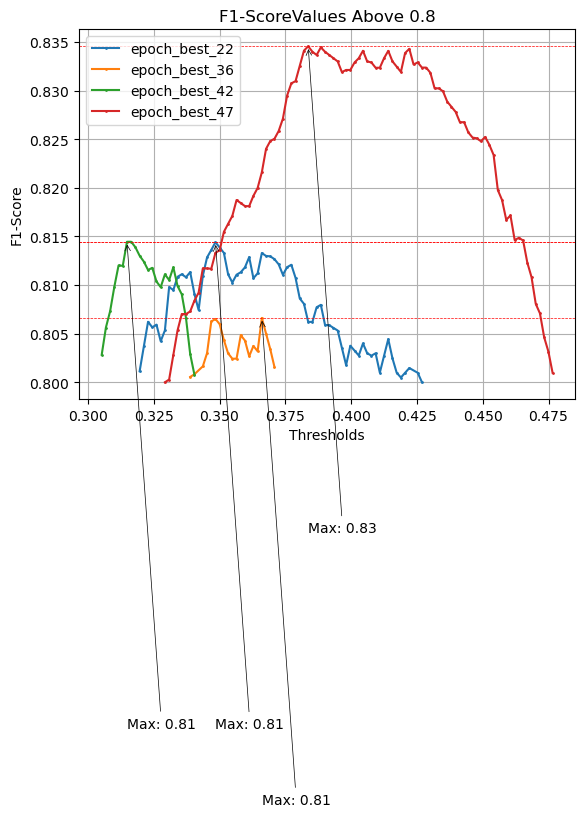

In [6]:
## 각 모델별 단순 F1-Score의 최고값을 분석 
best_model = ''
best_f1_score = 0
# find and plot for f1max
for key in metric_df_keys:
    if isinstance(metric_df[key], list):
        df = metric_df[key][0]
    else:
        df = metric_df[key]
    max_f1_score = df["F1-Score"].max()
    if max_f1_score > best_f1_score:
        best_f1_score = max_f1_score
        best_model = key
    corresponding_threshold = df[df["F1-Score"] == max_f1_score]["Thresholds"].values[0]
    corresponding_recall = df[df["F1-Score"] == max_f1_score]["Recall (TPR)"].values[0]
    print(key + f"'s Best F1-Score:\t {max_f1_score}, \tRecall: {corresponding_recall}, \tat thresholds: {corresponding_threshold}")
plot_metric_above_threshold(x_label="Thresholds", y_label="F1-Score", data=metric_df)


epoch_66's F1-Score at closest threshold to 0.5:	 0.645905420991926, 	Recall: 0.8408408408408409, 	at thresholds: 0.5005751503006012
epoch_83's F1-Score at closest threshold to 0.5:	 0.6793852676205617, 	Recall: 0.7667464114832536, 	at thresholds: 0.5005751503006012
epoch_best_22's F1-Score at closest threshold to 0.5:	 0.7399577167019028, 	Recall: 0.875, 	at thresholds: 0.5005751503006012
epoch_best_36's F1-Score at closest threshold to 0.5:	 0.683969465648855, 	Recall: 0.8145454545454546, 	at thresholds: 0.5005751503006012
epoch_best_42's F1-Score at closest threshold to 0.5:	 0.6915322580645161, 	Recall: 0.8458692971639951, 	at thresholds: 0.5005751503006012
epoch_best_47's F1-Score at closest threshold to 0.5:	 0.7738927738927738, 	Recall: 0.8137254901960784, 	at thresholds: 0.5005751503006012
Best model around threshold 0.5 is epoch_best_47 with F1-Score: 0.7738927738927738 and Recall: 0.8137254901960784 at threshold: 0.5005751503006012


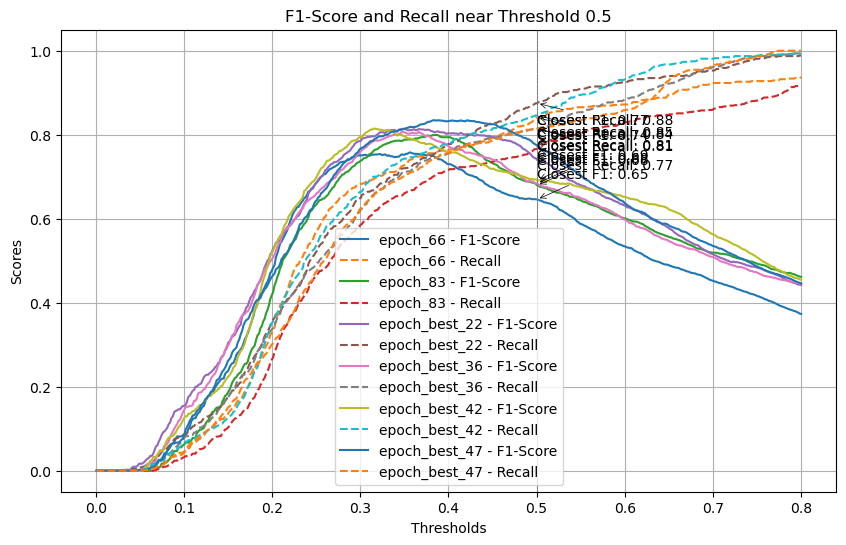

In [7]:
# threshold값이 0.5일때의 F1-Score와 Recall을 분석
# Initialize variables for storing the best model around threshold 0.5
best_f1_at_threshold_05 = 0
best_recall_at_threshold_05 = 0
best_model_at_threshold_05 = ''
closest_threshold = 0

# Iterate through each model to find the threshold closest to 0.5 and corresponding F1-Score and Recall
for key in metric_df_keys:
    if isinstance(metric_df[key], list):
        df = metric_df[key][0]
    else:
        df = metric_df[key]
    
    # Find the index of the threshold closest to 0.5
    threshold_diff = (df["Thresholds"] - 0.5).abs()
    closest_index = threshold_diff.idxmin()
    
    f1_at_closest_threshold = df.loc[closest_index, "F1-Score"]
    recall_at_closest_threshold = df.loc[closest_index, "Recall (TPR)"]
    closest_threshold_value = df.loc[closest_index, "Thresholds"]
    
    print(key + f"'s F1-Score at closest threshold to 0.5:\t {f1_at_closest_threshold}, \tRecall: {recall_at_closest_threshold}, \tat thresholds: {closest_threshold_value}")
    
    # Update if this F1-Score is the best one at the threshold 0.5
    if f1_at_closest_threshold > best_f1_at_threshold_05:
        best_f1_at_threshold_05 = f1_at_closest_threshold
        best_recall_at_threshold_05 = recall_at_closest_threshold
        best_model_at_threshold_05 = key
        closest_threshold = closest_threshold_value

# Print the best model and its corresponding F1-Score and Recall near threshold 0.5
print(f"Best model around threshold 0.5 is {best_model_at_threshold_05} with F1-Score: {best_f1_at_threshold_05} and Recall: {best_recall_at_threshold_05} at threshold: {closest_threshold}")

# Plot the F1-Score vs Thresholds for each model
plot_f1_and_recall_near_threshold(metric_df, threshold=0.5)


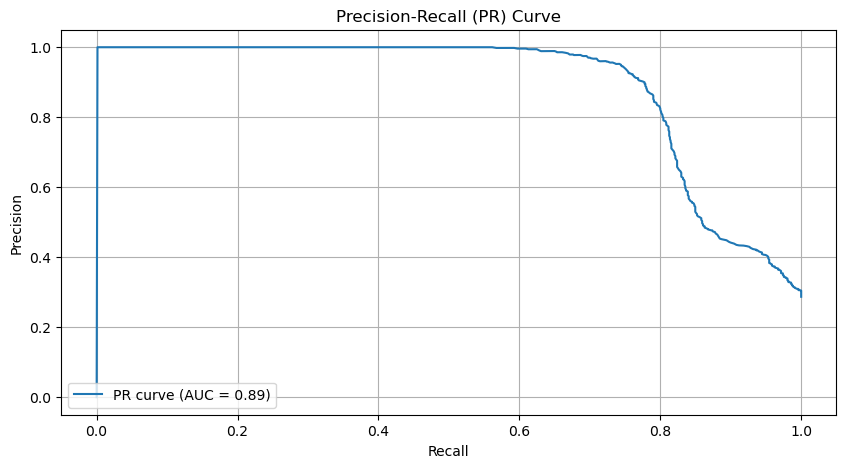

AUC-PR: 0.89


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_auc_graphs(df):
    # Extract necessary columns for ROC and PR curve
    # thresholds = df['Thresholds']
    # tpr = df['Recall (TPR)']  # True Positive Rate (Recall)
    # fpr = df['False Positive Rate (FPR)']  # False Positive Rate
    precision = df['Precision']
    recall = df['Recall (TPR)']
    
    # Calculate AUC for ROC curve
    # auc_roc = auc(fpr, tpr)
    
    # Calculate AUC for PR curve
    auc_pr = auc(recall, precision)
    
    # Plot ROC Curve
    # plt.figure(figsize=(10, 5))
    # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.2f})')
    # plt.xlabel('False Positive Rate (FPR)')
    # plt.ylabel('True Positive Rate (Recall)')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    # plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.show()

    # Plot Precision-Recall (PR) Curve
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, label=f'PR curve (AUC = {auc_pr:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    
    # Print AUC values
    # print(f"AUC-ROC: {auc_roc:.2f}")
    print(f"AUC-PR: {auc_pr:.2f}")

# Assuming 'df' is your dataframe
plot_auc_graphs(df)


In [9]:
# print best model at best threshold
best_df = metric_df[best_model]
best_f1_score = best_df["F1-Score"].max()
best_metric = best_df[best_df["F1-Score"] == best_f1_score]
print(f"Best Model: {best_model}, Best F1-Score: {best_f1_score}")
print(best_metric)

Best Model: epoch_best_47, Best F1-Score: 0.8345612860013397
     Thresholds  True Positives  True Negatives  False Positives  \
239    0.383687             623            4170               33   

     False Negatives  Precision  Recall (TPR)  F1-Score  Accuracy  \
239              214   0.949695      0.744325  0.834561  0.950992   

     False Positive Rate (FPR)  Top-5 Recall  
239                   0.007852      0.744325  


In [10]:
# Find the index of the threshold closest to 0.598248
target_threshold = 0.383687
closest_index = (best_df["Thresholds"] - target_threshold).abs().idxmin()
print(f"The index of the closest threshold to {target_threshold} is {closest_index}")

The index of the closest threshold to 0.383687 is 239
